In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from timezonefinder import TimezoneFinder
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import random

# set cwd to src
os.chdir('../src')
from utils import normal

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

## Load Data

In [2]:
X = pd.read_csv('../results/csvs/training_data_2023-01-01_to_2023-01-10.csv')
X2 = pd.read_csv('../results/csvs/training_data_2022-12-30_to_2022-12-31.csv')
X3 = pd.read_csv('../results/csvs/training_data_2022-12-20_to_2022-12-29.csv')
X4 = pd.read_csv('../results/csvs/training_data_2023-01-11_to_2023-01-16.csv')
X5 = pd.read_csv('../results/csvs/training_data_2023-01-17_to_2023-01-23.csv')
X = pd.concat([X, X2, X3, X4, X5], ignore_index=True)  # combine the 3 athena queries
X.to_csv('../results/csvs/training_data_2022-12-20_to_2023-01-23.csv', index=False)

y = pd.read_csv('../data/IrvineSpectrumCenter_parking_2022-11_to_2023-03.csv')
lot_ids = list(X['pk_lot'].unique())
y = y[y['pk_lot'].isin(lot_ids)]

# convert timestamp to datetime when the rows have different timezones
X['timestamp'] = pd.to_datetime(X['timestamp'])
X['hour'] = X['timestamp'].dt.hour
X['day_of_week'] = X['timestamp'].dt.dayofweek
min_time = X['timestamp'].min()
max_time = X['timestamp'].max()

y['timestamp'] = pd.to_datetime(y['dt_start_date'])
y['timestamp'] = y['timestamp'].apply(lambda x: x.replace(microsecond=0))
y['timestamp'] = y['timestamp'].dt.tz_convert('US/Pacific')
y.drop(columns=['dt_start_date', 'dt_end_date', 'pk_lot_alias', 'f_occupancy_rank'], inplace=True)
y = y[(y['timestamp'] >= min_time) & (y['timestamp'] <= max_time)]

X = X.sort_values(by=['timestamp'])
y = y.sort_values(by=['timestamp'])
display(X.head(2))
display(y.head(2))
print('X shape:', X.shape)
print('y shape:', y.shape)

,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,long_hotspot,long_wasserstein,long_log_prob,long_hunting_time,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week
4416,0.541240,2.536337,11.084475,85.0,0.112782,0.541240,2.256224,11.084475,85.0,0.023220,0.541240,2.420517,11.084475,85.0,0.010388,387459,2022-12-19 16:17:25-08:00,16,0
4417,0.052708,1.261729,12.495681,252.0,0.060729,0.052708,1.336342,12.495681,252.0,0.016112,0.052708,1.417956,12.495681,252.0,0.004563,381381,2022-12-19 16:19:06-08:00,16,0


,i_avail,i_occ,f_pct_occ,pk_lot,location,geometry,timestamp
17550,27,NaN,86.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -...",2022-12-19 16:21:56-08:00
17551,439,NaN,69.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -...",2022-12-19 16:21:56-08:00


X shape: (13276, 19)
y shape: (10872, 7)


Confirm we have temporal coverage

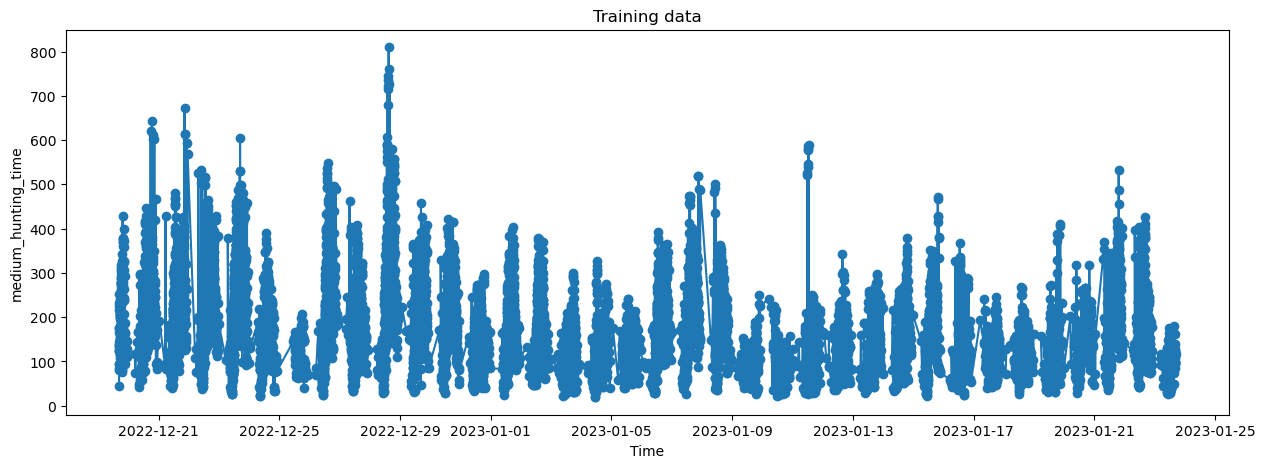

In [3]:
att = 'medium_hunting_time'
plt.figure(figsize=(15, 5))
plt.plot(X['timestamp'], X[att], marker='o')
plt.xlabel('Time')
plt.ylabel(att)
plt.title('Training data')
plt.show()

For each row of X, let it inherit the ground truth value from the row in y with the same parking lot and nearest timestamp

In [4]:
y = y[['timestamp', 'pk_lot', 'f_pct_occ', 'i_avail']]

In [5]:
merged_df = X.merge(y, on='pk_lot', suffixes=('', '_y'))

merged_df['time_diff'] = (merged_df['timestamp'] - merged_df['timestamp_y']).dt.total_seconds().abs()
df = merged_df.sort_values(by=['pk_lot', 'timestamp', 'time_diff']).drop_duplicates(subset=['pk_lot', 'timestamp'], keep='first')
df = df.drop(columns=['timestamp_y', 'time_diff'])
display(df.head(2))
print('df shape:', df.shape)

,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,...,long_wasserstein,long_log_prob,long_hunting_time,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week,f_pct_occ,i_avail
5436,0.264443,3.019982,10.364312,143.0,0.197368,0.264443,2.640357,10.364312,143.0,0.032895,...,2.851521,10.364312,143.0,0.015480,329825,2022-12-19 16:23:59-08:00,16,0,79.0,51
47113,0.244699,1.811102,11.950688,86.0,0.394737,0.254571,2.399649,11.157500,114.5,0.075188,...,2.241234,11.157500,114.5,0.030364,329825,2022-12-19 16:54:55-08:00,16,0,79.0,51


df shape: (13255, 21)


,pk_lot,hour,day_of_week,typical_f_pct_occ,hour_of_week
0,329825,6,0,21.857143,6
4,329825,7,0,21.000000,7
11,329825,8,0,25.000000,8
18,329825,9,0,32.266667,9
25,329825,10,0,48.411765,10
...,...,...,...,...,...
676,387459,16,6,69.960000,160
683,387459,17,6,66.400000,161
690,387459,18,6,61.000000,162
697,387459,19,6,54.666667,163


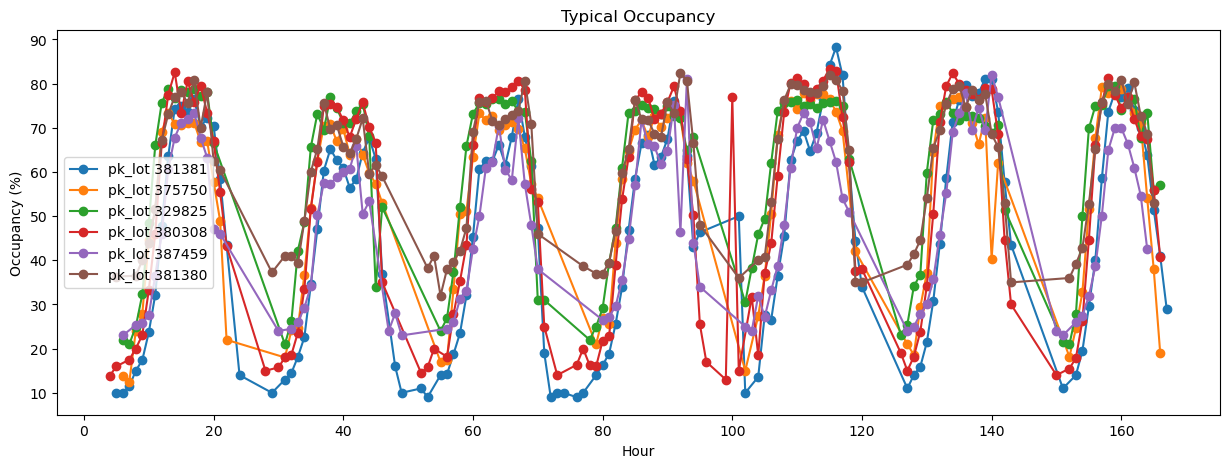

In [6]:
# typical occupancy for each (lot, hour, day_of_week) tuple
typical_occupancy = df.groupby(['pk_lot', 'hour', 'day_of_week'])['f_pct_occ'].mean().reset_index()
typical_occupancy['hour_of_week'] = typical_occupancy['day_of_week'] * 24 + typical_occupancy['hour']
typical_occupancy = typical_occupancy.sort_values(by=['pk_lot', 'hour_of_week'])
typical_occupancy = typical_occupancy.rename(columns={'f_pct_occ': 'typical_f_pct_occ'})
display(typical_occupancy)

# make a plot of each lot's typical occupancy
plt.figure(figsize=(15, 5))
for lot_id in lot_ids:
    lot_df = typical_occupancy[typical_occupancy['pk_lot'] == lot_id]
    plt.plot(lot_df['hour_of_week'], lot_df['typical_f_pct_occ'], label=f'pk_lot {lot_id}', marker='o')
plt.xlabel('Hour')
plt.ylabel('Occupancy (%)')
plt.title('Typical Occupancy')
plt.legend()
plt.show()

In [7]:
# which lot has the most number of total trips
lot_counts = df['pk_lot'].value_counts().reset_index()
lot_counts.columns = ['pk_lot', 'count']
lot_counts

,pk_lot,count
0,381381,4467
1,380308,2952
2,387459,1548
3,375750,1517
4,329825,1386
5,381380,1385


## Analyze the Residuals

Merge the typical occupancy to the df

In [8]:
orig_size = df.shape[0]
df = pd.merge(df, typical_occupancy, on=['pk_lot', 'hour', 'day_of_week'], how='inner')
assert orig_size == df.shape[0]
df['delta'] = df['f_pct_occ'] - df['typical_f_pct_occ']
display(df.head(5))
# this doesn't do anything when you have less than a week of data

,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,...,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week,f_pct_occ,i_avail,typical_f_pct_occ,hour_of_week,delta
0,0.264443,3.019982,10.364312,143.0,0.197368,0.264443,2.640357,10.364312,143.00,0.032895,...,0.015480,329825,2022-12-19 16:23:59-08:00,16,0,79.0,51,78.200000,16,0.800000
1,0.244699,1.811102,11.950688,86.0,0.394737,0.254571,2.399649,11.157500,114.50,0.075188,...,0.030364,329825,2022-12-19 16:54:55-08:00,16,0,79.0,51,78.200000,16,0.800000
2,0.196472,1.607474,11.700638,50.0,0.592105,0.235204,1.835793,11.338546,93.00,0.112782,...,0.045547,329825,2022-12-19 17:03:48-08:00,17,0,79.0,51,78.869565,17,0.130435
3,0.205711,1.560663,11.850106,662.0,0.789474,0.227831,1.301060,11.466436,235.25,0.150376,...,0.060729,329825,2022-12-19 17:06:41-08:00,17,0,79.0,51,78.869565,17,0.130435
4,0.174392,1.741150,11.373316,141.0,1.315789,0.217143,0.936204,11.447812,216.40,0.219298,...,0.077399,329825,2022-12-19 17:20:27-08:00,17,0,79.0,51,78.869565,17,0.130435


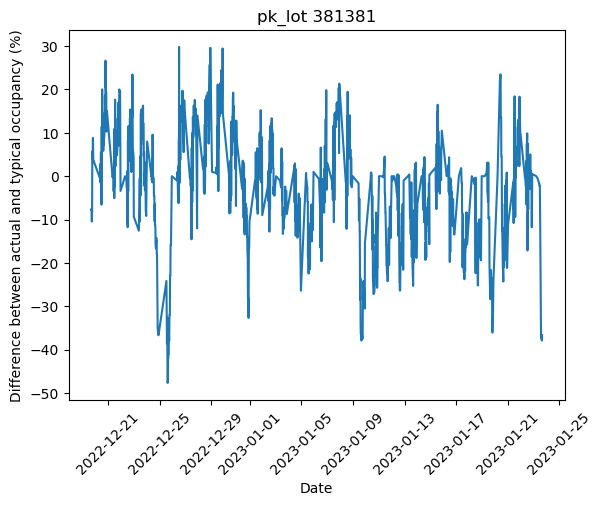

In [9]:
# plot the delta vs. timestamp for first week for random lot
lot_id = np.random.choice(lot_ids)
start_date = '2022-11-01'
end_date = '2023-03-31'
week_df = df[(df['timestamp'] > start_date) & (df['timestamp'] < end_date) & (df['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['delta'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Difference between actual and typical occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

Plot distribution of deltas

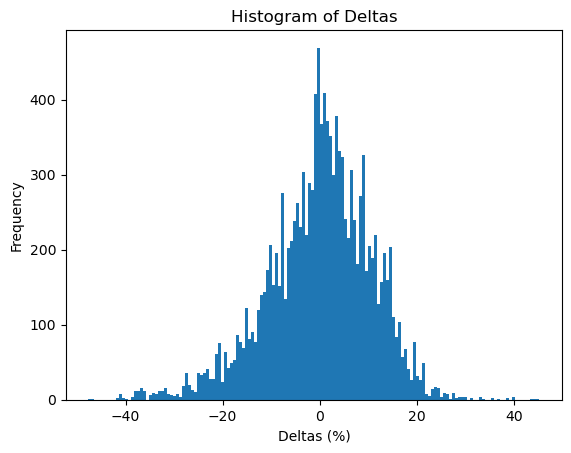

In [10]:
bins = 150
plt.hist(df['delta'], bins=bins)
plt.xlabel('Deltas (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Deltas')
plt.show()

If it was normal...

Mean: -6.861521703303872e-17
Standard Deviation: 10.695036150819167


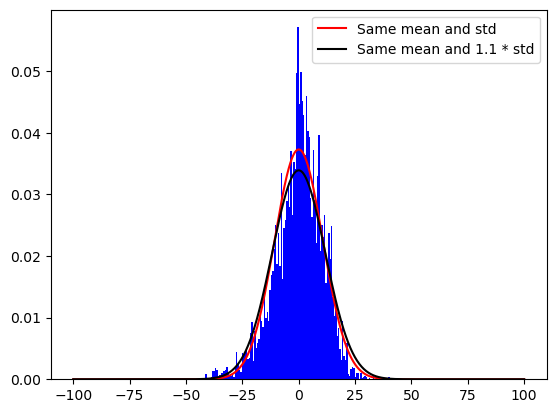

In [11]:
mean = df['delta'].mean()
std = df['delta'].std()
print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')

# plot a normal distribution with the same mean and new standard deviation
x = np.linspace(-100, 100, 1000)
y = normal(x, mean, std)
plt.plot(x, y, color='red', label='Same mean and std')

std_multiplier = 1.1
new_std = std * std_multiplier
x = np.linspace(-100, 100, 1000)
y = (1 / (new_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / new_std) ** 2)
plt.plot(x, y, color='black', label=f'Same mean and {std_multiplier} * std')

# plot the histogram of deltas
plt.hist(df['delta'], bins=bins, density=True, color='b')
plt.legend()
plt.show()

Resample to make deltas normal

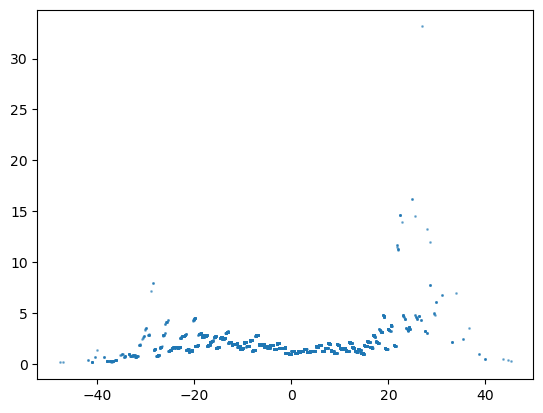

In [12]:
dframe = df.copy()
# given a delta value, how many rows are in the same bin as it?
dframe['bin'] = pd.cut(dframe['delta'], bins=bins, labels=False)
bin_counts = dframe['bin'].value_counts(normalize=True).reset_index()
bin_counts.columns = ['bin', 'bin_percent']

# join the bin_percent to dframe
dframe = pd.merge(dframe, bin_counts, on='bin', how='inner')
# normal distribution
dframe['weight'] = normal(dframe['delta'].values, mean, new_std) / dframe['bin_percent'].values
# uniform  distribution
# dframe['weight'] = 1 / dframe['bin_percent'].values

plt.scatter(dframe['delta'], dframe['weight'], s=1, alpha = 0.5)
plt.show()

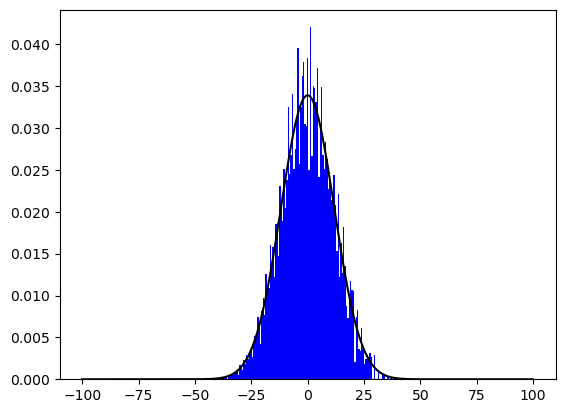

In [13]:
resamp = dframe.copy()
multiplier = 8
resamp = resamp.sample(n=multiplier * dframe.shape[0], replace=True, weights=resamp['weight'])
resamp = resamp.drop(columns=['bin', 'bin_percent', 'weight'])

# plot the histogram of deltas
plt.hist(resamp['delta'], bins=bins, density=True, color='b')
# plt.show()

# plot a normal distribution with the same mean and standard deviation
x = np.linspace(-100, 100, 1000)
y = normal(x, mean, new_std)
plt.plot(x, y, color='black')
plt.show()

In [14]:
# df = resamp.copy()  # if you want to work with normalized deltas dataset

## Trend Features

Perhaps the change in metrics between short, medium, and long term will give an indication of occupancy

In [15]:
feats = ['hotspot', 'wasserstein', 'log_prob', 'hunting_time', 'in_out_ratio']
for feat in feats:
    df[f'trend_near_{feat}'] = df[f'short_{feat}'] - df[f'medium_{feat}']
    df[f'trend_far_{feat}'] = df[f'short_{feat}'] - df[f'long_{feat}']
    df[f'trend_lag_{feat}'] = df[f'medium_{feat}'] - df[f'long_{feat}']
# display all columns
pd.set_option('display.max_columns', None)
print(df.shape)
df.head(3)

(13255, 39)


,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,long_hotspot,long_wasserstein,long_log_prob,long_hunting_time,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week,f_pct_occ,i_avail,typical_f_pct_occ,hour_of_week,delta,trend_near_hotspot,trend_far_hotspot,trend_lag_hotspot,trend_near_wasserstein,trend_far_wasserstein,trend_lag_wasserstein,trend_near_log_prob,trend_far_log_prob,trend_lag_log_prob,trend_near_hunting_time,trend_far_hunting_time,trend_lag_hunting_time,trend_near_in_out_ratio,trend_far_in_out_ratio,trend_lag_in_out_ratio
0,0.264443,3.019982,10.364312,143.0,0.197368,0.264443,2.640357,10.364312,143.0,0.032895,0.264443,2.851521,10.364312,143.0,0.015480,329825,2022-12-19 16:23:59-08:00,16,0,79.0,51,78.200000,16,0.800000,0.000000,0.000000,0.0,0.379625,0.168461,-0.211164,0.000000,0.000000,0.0,0.0,0.0,0.0,0.164474,0.181889,0.017415
1,0.244699,1.811102,11.950688,86.0,0.394737,0.254571,2.399649,11.157500,114.5,0.075188,0.254571,2.241234,11.157500,114.5,0.030364,329825,2022-12-19 16:54:55-08:00,16,0,79.0,51,78.200000,16,0.800000,-0.009872,-0.009872,0.0,-0.588547,-0.430131,0.158415,0.793188,0.793188,0.0,-28.5,-28.5,0.0,0.319549,0.364372,0.044824
2,0.196472,1.607474,11.700638,50.0,0.592105,0.235204,1.835793,11.338546,93.0,0.112782,0.235204,1.842618,11.338546,93.0,0.045547,329825,2022-12-19 17:03:48-08:00,17,0,79.0,51,78.869565,17,0.130435,-0.038732,-0.038732,0.0,-0.228319,-0.235144,-0.006825,0.362092,0.362092,0.0,-43.0,-43.0,0.0,0.479323,0.546559,0.067235


## Feature Validation

In [16]:
# get the columns of X that start with 'short', 'medium', and 'long'
SHORT_FEATS = [col for col in X.columns if col.startswith('short')]
MEDIUM_FEATS = [col for col in X.columns if col.startswith('medium')]
LONG_FEATS = [col for col in X.columns if col.startswith('long')]
TIME_FEATS = ['hour', 'day_of_week']
TREND_NEAR_FEATS = [col for col in df.columns if col.startswith('trend_near')]
TREND_FAR_FEATS = [col for col in df.columns if col.startswith('trend_far')]
TREND_LAG_FEATS = [col for col in df.columns if col.startswith('trend_lag')]
TREND_FEATS = TREND_NEAR_FEATS + TREND_FAR_FEATS + TREND_LAG_FEATS
FEATS = SHORT_FEATS + MEDIUM_FEATS + LONG_FEATS + TIME_FEATS + TREND_FEATS
print('Number of features:', len(FEATS))

Number of features: 32


Old size: 367, New size: 367


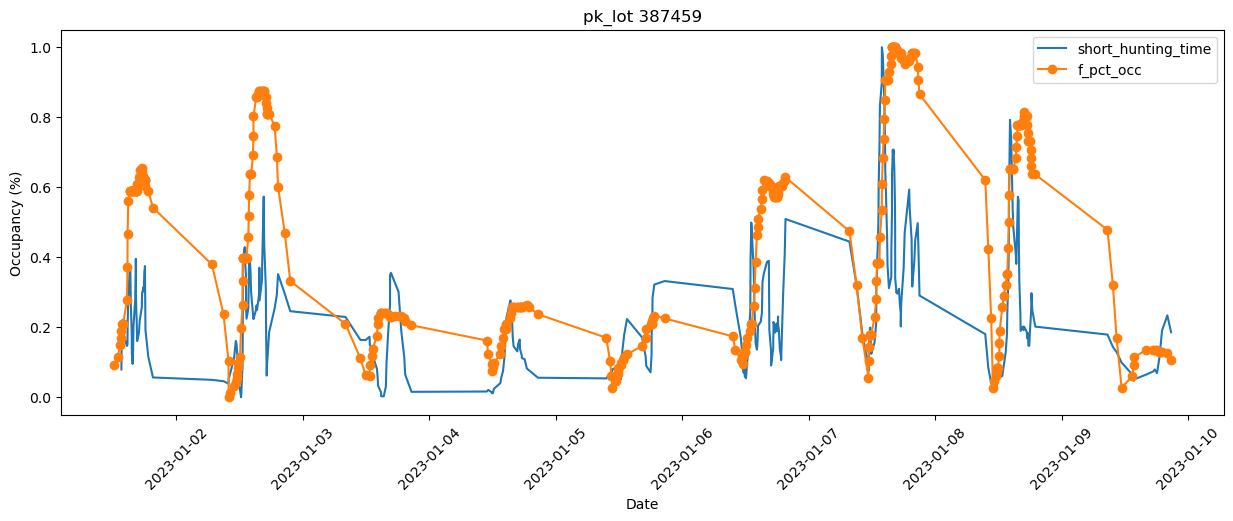

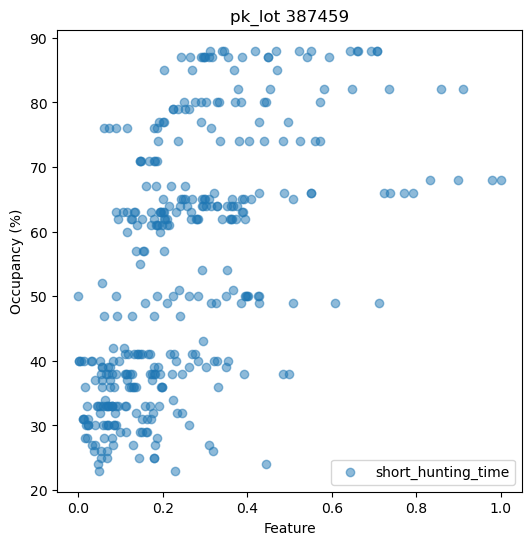

In [17]:
# plot the normalized input features with the output features over time
input_features = ['short_hunting_time'] #FEATS
output_feature = 'f_pct_occ'
lot_id = np.random.choice(lot_ids)
# pick a random start date
start_month = 1
start_date = 1
end_date = 10
window = 4
start_date = f'2023-0{start_month}-{start_date}'
end_date = f'2023-0{start_month}-{end_date}'
week_df = df[(df['timestamp'] > start_date) & (df['timestamp'] < end_date) & (df['pk_lot'] == lot_id)].copy()
# drop all duplicates except 1
orig_size = week_df.shape[0]
week_df = week_df.drop_duplicates(subset=['timestamp'], keep='first')
week_df = week_df.sort_values(by=['timestamp'])
new_size = week_df.shape[0]
print(f'Old size: {orig_size}, New size: {new_size}')

# apply smoothing to some features
for feat in input_features:
    week_df[feat] = week_df[feat].rolling(window=4).mean()

# line plot
plt.figure(figsize=(15, 5))
feats = input_features + [output_feature]
for feat in feats:
    rolled = week_df[feat].rolling(window=window).mean()
    data = (rolled.values - rolled.min()) / (rolled.max() - rolled.min())
    if feat == output_feature:
        plt.plot(week_df['timestamp'], data, marker='o', label=feat)
    else:
        plt.plot(week_df['timestamp'], data, label=feat)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()


# scatterplot of features with occupancy
plt.figure(figsize=(6, 6))
for feat in input_features:
    rolled = week_df[feat].rolling(window=window).mean()
    data = (rolled.values - rolled.min()) / (rolled.max() - rolled.min())
    plt.scatter(data, week_df[output_feature], label=feat, alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()

Train the Model

In [18]:
BEST_FEATS = ['short_hotspot', 'short_log_prob', 'short_hunting_time', 'short_in_out_ratio',
              'medium_log_prob', 'medium_hotspot', 'medium_hunting_time',
              'medium_in_out_ratio', 'long_wasserstein', 'long_log_prob',
              'long_hunting_time', 'trend_lag_log_prob', 'trend_lag_in_out_ratio',
              'trend_lag_hunting_time']

In [255]:
# input_features = SHORT_FEATS + MEDIUM_FEATS + LONG_FEATS + TREND_FEATS  # Best: .7, .52 r2
input_features = BEST_FEATS  # Best: .7, .58 r2
# input_features = FEATS  # Best: .75, .42 time r2
output_feature = 'f_pct_occ'

reduce = False
components = 15
test_day = '2022-12-26 12:00'  # set aside some time for testing
hide_end = False  # if we want to test on the future data after test_day
test_lots = [329825]  # set aside some lots for testing
if hide_end:
    df_train = df[(df['timestamp'] <= test_day) & (~df['pk_lot'].isin(test_lots))].copy()
    time_test = df[df['timestamp'] > test_day].copy()
else:
    df_train = df[(test_day <= df['timestamp']) & (~df['pk_lot'].isin(test_lots))].copy()
    time_test = df[df['timestamp'] < test_day].copy()
lot_test = df[df['pk_lot'].isin(test_lots)].copy()

X_train = df_train[input_features].values
y_train = df_train[output_feature].values
X_time_test = time_test[input_features].values
y_time_test = time_test[output_feature].values
X_lot_test = lot_test[input_features].values
y_lot_test = lot_test[output_feature].values

train_size = len(X_train)
time_test_size = len(X_time_test)
lot_test_size = len(X_lot_test)
print(f'Train size: {train_size}, Time Test size: {time_test_size}, Lot Test size: {lot_test_size}')
print(f'{train_size / (train_size + time_test_size + lot_test_size) * 100:.2f}% training data')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_time_test = scaler.transform(X_time_test)
X_lot_test = scaler.transform(X_lot_test)

# dimension reduction
if reduce:
    pca = PCA(n_components=components)
    X_train = pca.fit_transform(X_train)
    X_time_test = pca.transform(X_time_test)
    X_lot_test = pca.transform(X_lot_test)

# model = RandomForestRegressor(n_estimators=2000, max_depth=50)
model = XGBRegressor(
    n_estimators=3200,
    learning_rate=0.001,
    max_depth=8,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.9,
    alpha=0.01,
)
print(model)
model.fit(X_train, y_train)

# evaluate on unseen times
y_time_pred = model.predict(X_time_test)
time_mse = mean_squared_error(y_time_test, y_time_pred)
print(f'Time MSE: {time_mse}')
time_r2 = r2_score(y_time_test, y_time_pred)
print(f'Time R^2: {time_r2}')

# evaluate on unseen lots
y_lot_pred = model.predict(X_lot_test)
lot_mse = mean_squared_error(y_lot_test, y_lot_pred)
print(f'Lot MSE: {lot_mse}')
lot_r2 = r2_score(y_lot_test, y_lot_pred)
print(f'Lot R^2: {lot_r2}')

Train size: 9351, Time Test size: 2788, Lot Test size: 1386
69.14% training data
XGBRegressor(alpha=0.01, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3200, n_jobs=None,
             num_parallel_tree=None, ...)
Time MSE: 114.6587819098551
Time R^2: 0.6981983508111171
Lot MSE: 133.68027638480248
Lot R^2: 0.5218383774301909


In [256]:
if reduce:    
    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_

    # Plot explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
    plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', linestyle='--', color='red')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

In [257]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [2000, 3500, 5000],
#     'max_depth': [6, 10],
#     'min_child_weight': [3, 5],
#     'learning_rate': [0.001, 0.01],
# }

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=3,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)
# print("Best parameters found: ", grid_search.best_params_)

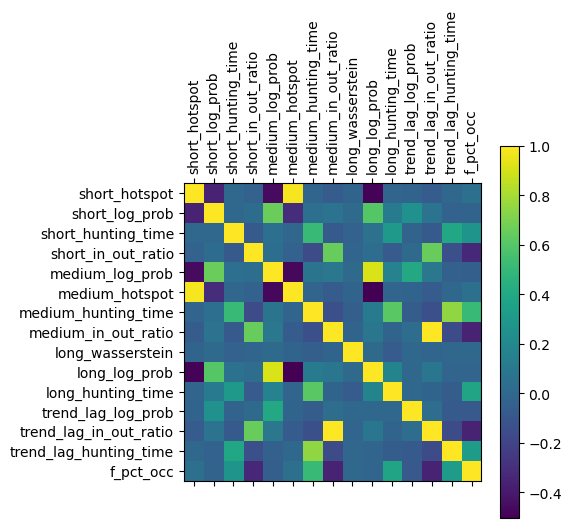

In [258]:
# plot a correlation matrix between the input features and the output feature
corr = df[input_features + [output_feature]].corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

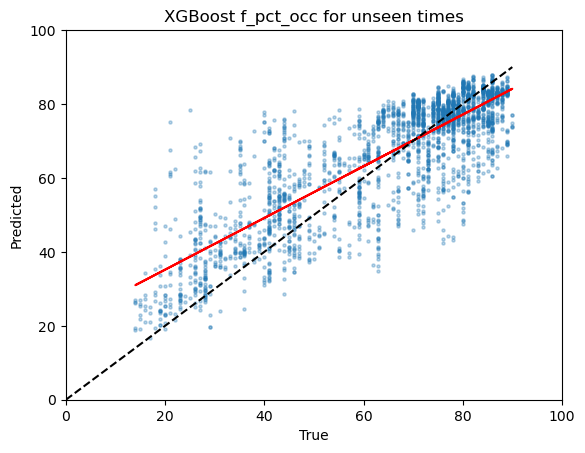

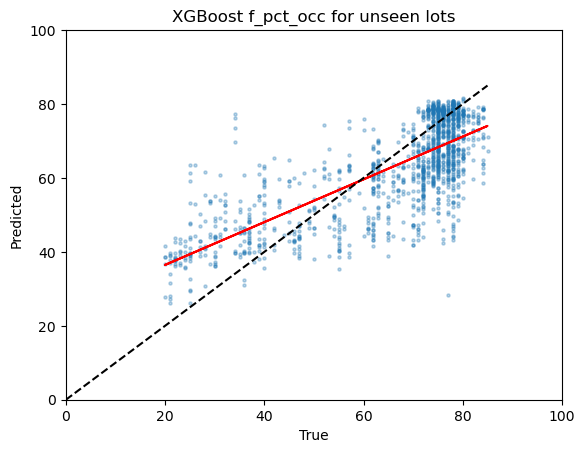

[('short_hotspot', 0.019033693), ('short_log_prob', 0.013267396), ('short_hunting_time', 0.020622632), ('short_in_out_ratio', 0.16991895), ('medium_log_prob', 0.024569308), ('medium_hotspot', 0.042619463), ('medium_hunting_time', 0.19619341), ('medium_in_out_ratio', 0.26125893), ('long_wasserstein', 0.018024452), ('long_log_prob', 0.034309056), ('long_hunting_time', 0.07146526), ('trend_lag_log_prob', 0.019739462), ('trend_lag_in_out_ratio', 0.06948829), ('trend_lag_hunting_time', 0.039489653)]


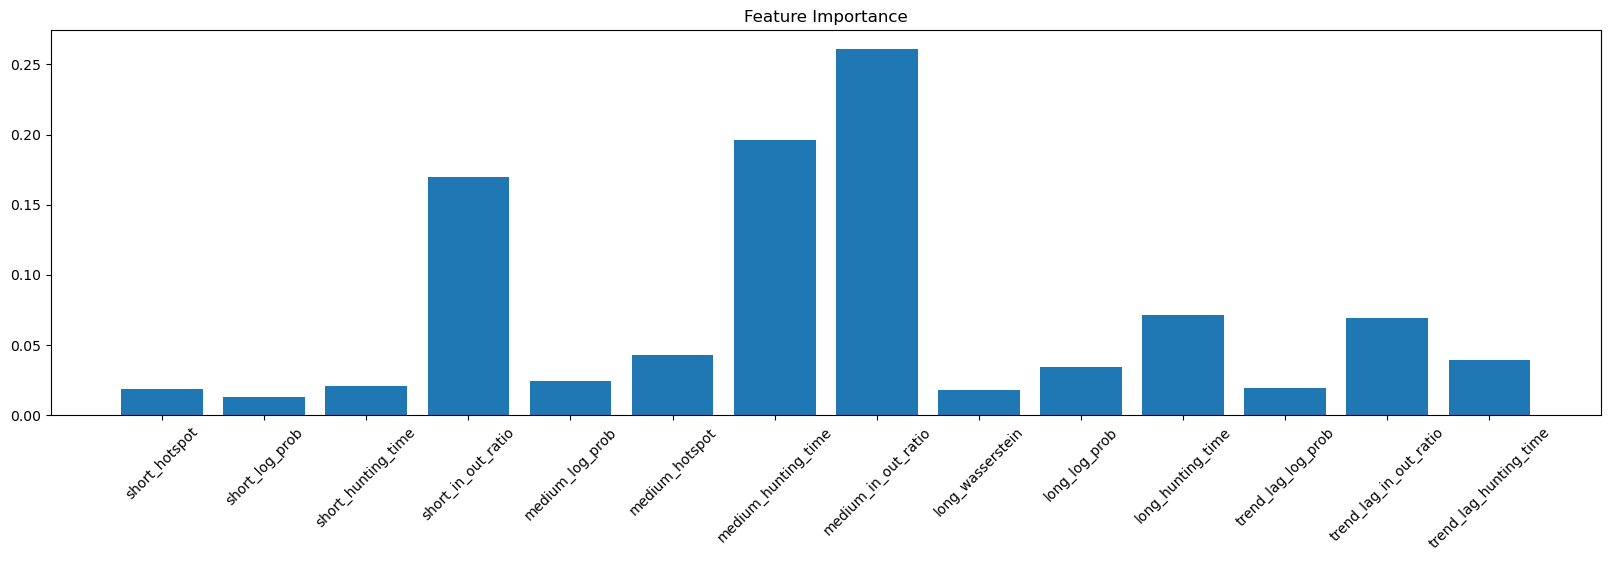

In [259]:
# visualize time results
plt.scatter(y_time_test, y_time_pred, s=5, alpha=0.3)
# line of best fit
m, b = np.polyfit(y_time_test, y_time_pred, 1)
plt.plot(y_time_test, m*y_time_test + b, color='red')
max_val = max(max(y_time_test), max(y_time_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'XGBoost {output_feature} for unseen times')
plt.show()

# visualize lot results
plt.scatter(y_lot_test, y_lot_pred, s=5, alpha=0.3)
# line of best fit
m, b = np.polyfit(y_lot_test, y_lot_pred, 1)
plt.plot(y_lot_test, m*y_lot_test + b, color='red')
max_val = max(max(y_lot_test), max(y_lot_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'XGBoost {output_feature} for unseen lots')
plt.show()

# plot feature importance
fig = plt.figure(figsize=(20, 5))
importance = model.feature_importances_
print([(f, i) for f, i in zip(input_features, importance)])
plt.bar([x for x in range(len(importance))], importance)
if reduce:
    labels = [f'PC{x + 1}' for x in range(components)]
else:
    labels = input_features
plt.xticks(ticks=[x for x in range(len(importance))], rotation=45, labels=labels)
plt.title('Feature Importance')
plt.show()

Predicted time series for pk_lot 381380 from 2022-12-01 to 2023-01-01


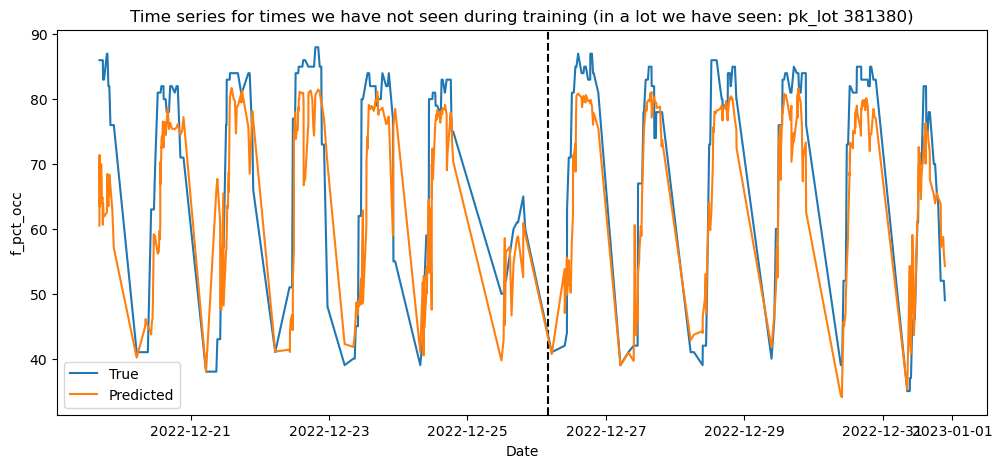

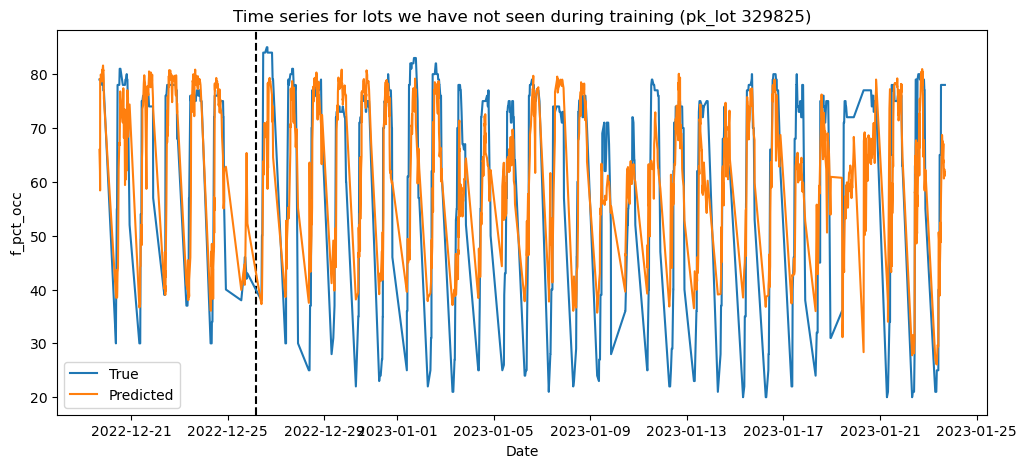

In [269]:
# plot the predicted time series for unseen time data
# get the first week of data for a random lot that we were trained on
train_lots = list(set(lot_ids) - set(test_lots))
lot_id = np.random.choice(train_lots)
start_date = '2022-12-01'
end_date = '2023-01-01'
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
if reduce:
    week = pca.transform(week)
week_pred = model.predict(week)

print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'Time series for times we have not seen during training (in a lot we have seen: pk_lot {lot_id})')
plt.legend()
plt.show()


# plot the predicted time series for unseen lot data
lot_id = np.random.choice(test_lots)
start_date = '2022-12-01'
end_date = '2023-03-31'
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
if reduce:
    week = pca.transform(week)
week_pred = model.predict(week)

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'Time series for lots we have not seen during training (pk_lot {lot_id})')
plt.legend()
plt.show()

## Train a Prohpet model on the ground truth

In [261]:
lot_id = np.random.choice(train_lots)
print(f'Lot ID: {lot_id}')
print(f'Test day: {test_day}')

Lot ID: 381381
Test day: 2022-12-26 12:00


In [262]:
ts = df[['timestamp', 'pk_lot', 'f_pct_occ']].copy()
# remove the timezone from ts
ts['timestamp'] = ts['timestamp'].dt.tz_localize(None)
ts = ts.rename(columns={'timestamp': 'ds', 'f_pct_occ': 'y'})
ts = ts[ts['pk_lot'] == lot_id]

if hide_end:
    ts_train = ts[ts['ds'] <= test_day]
    ts_test = ts[ts['ds'] > test_day]
else:
    ts_train = ts[ts['ds'] >= test_day]
    ts_test = ts[ts['ds'] < test_day]

# ts_train = ts_train[ts_train['pk_lot'] == lot_id].copy()

m = Prophet()
m.fit(ts_train)

# future = ts
# future = m.make_future_dataframe(periods=365)
forecast = m.predict(ts)
forecast['y'] = ts['y'].values  # add the true values
forecast['pk_lot'] = ts['pk_lot'].values  # add the lot ids
print(f'Min time: {forecast["ds"].min()}, Max time: {forecast["ds"].max()}')
forecast[['ds', 'pk_lot', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

14:17:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:19 - cmdstanpy - INFO - Chain [1] done processing


Min time: 2022-12-19 16:19:06, Max time: 2023-01-23 16:10:39


,ds,pk_lot,y,yhat,yhat_lower,yhat_upper
0,2022-12-19 16:19:06,381381,66.0,77.690411,66.246685,89.858444
1,2022-12-19 16:20:27,381381,66.0,77.645548,65.843405,89.381985
2,2022-12-19 16:30:26,381381,66.0,77.315622,65.494112,90.010945


In [263]:
plot_plotly(m, forecast)

In [264]:
plot_components_plotly(m, forecast)

(1872, 4)


,timestamp,y,yhat,my_model
0,2022-12-19 16:19:06-08:00,66.0,77.690411,78.645897
1,2022-12-19 16:20:27-08:00,66.0,77.645548,73.072899
2,2022-12-19 16:30:26-08:00,66.0,77.315622,66.139572
3,2022-12-19 16:35:57-08:00,66.0,77.140283,69.941971
4,2022-12-19 16:37:54-08:00,66.0,77.080442,79.242241
...,...,...,...,...
1867,2022-12-31 22:20:10-08:00,41.0,57.615806,50.918098
1868,2022-12-31 22:29:43-08:00,41.0,54.927883,49.854984
1869,2022-12-31 22:31:31-08:00,41.0,54.420192,49.372944
1870,2022-12-31 22:33:54-08:00,41.0,53.748283,50.227268


Prophet MSE: 167.0996087712784
My Model MSE: 67.01269780106857
Predicted time series for pk_lot 381381 from 2022-12-01 to 2023-01-01


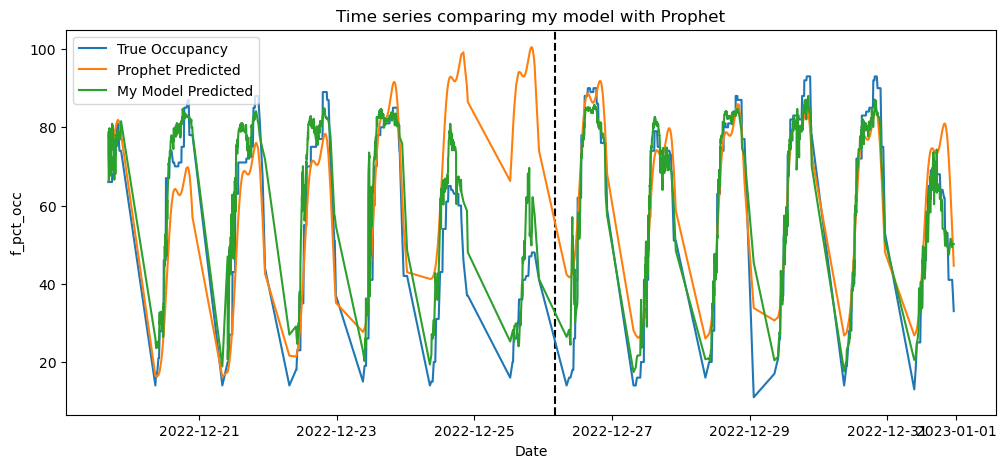

In [265]:
plot_df = forecast.copy()
plot_df['timestamp'] = pd.to_datetime(plot_df['ds'])
plot_df['timestamp'] = plot_df['timestamp'].dt.tz_localize('US/Pacific')

start_date = '2022-12-01'
end_date = '2023-01-01'

prophet_week = plot_df[(plot_df['timestamp'] < end_date) & (start_date < plot_df['timestamp'])]
prophet_week = prophet_week.sort_values(by=['timestamp'])

# get my model's predictions
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)].copy()
week = week_df[input_features].values
week = scaler.transform(week)
if reduce:
    week = pca.transform(week)
week_pred = model.predict(week)

comparison_df = prophet_week[['timestamp', 'y', 'yhat']].copy()
comparison_df['my_model'] = week_pred
print(comparison_df.shape)
display(comparison_df) #.head(10))

# get the MSE for the prophet model and my model
prophet_mse = mean_squared_error(comparison_df['y'], comparison_df['yhat'])
print(f'Prophet MSE: {prophet_mse}')
my_model_mse = mean_squared_error(comparison_df['y'], comparison_df['my_model'])
print(f'My Model MSE: {my_model_mse}')

print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(prophet_week['timestamp'], prophet_week['y'], label='True Occupancy')
plt.plot(prophet_week['timestamp'], prophet_week['yhat'], label='Prophet Predicted')
plt.plot(week_df['timestamp'], week_pred, label='My Model Predicted')
plt.xlabel('Date')
plt.ylabel('f_pct_occ')
plt.title(f'Time series comparing my model with Prophet')
plt.legend()
plt.show()